# Large Scale MVI

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from simpeg import utils
from simpeg.potential_fields import magnetics as mag
import pandas as pd

## Read in Data

In [3]:
df=pd.read_csv('Utils/QL_data.csv')

df = df[(df['x'] < 1.4530e7) & (df['y'] < -2.315e6)]

#Uncomment to run smaller problem
#df = df[(df['x'] < 1.45275e7) & (df['y'] < -2.32e6)]


In [4]:
#Grab what we need as np.arrays

rx_points = df.iloc[:,0:3].to_numpy()

dobs = df.tmi.to_numpy()

topo = df.iloc[:,[0,1,4]].to_numpy()

14720.0 meters in x direction
19311.0 meters in y direction


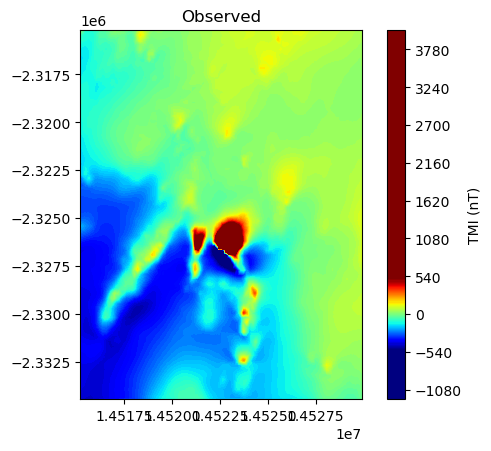

In [5]:
#Plot up the data
vmax = 500
vmin = -vmax
im=plt.tricontourf(df.x,df.y,df.tmi,cmap='jet',vmax=vmax,vmin=vmin,levels=500)
plt.title('Observed')
plt.gca().set_aspect('equal')
plt.colorbar(im,label='TMI (nT)')

#Define some values we will use later
min_x = df.x.min()
max_x = df.x.max()
mean_x = df.x.mean()
min_y = df.y.min()
max_y = df.y.max()
mean_y = df.y.mean()
min_z = df.z.min()
max_z = df.z.max()
mean_z = df.z.mean()
dist_x = max_x - min_x
dist_y = max_y - min_y

print(str(dist_x)+' meters in x direction')
print(str(dist_y)+' meters in y direction')

In [6]:
#Subtract off a second order polynomial regional trend

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

Xtrain = np.vstack((df.x-mean_x, df.y-mean_y)).T
model = LinearRegression()
poly = PolynomialFeatures(degree=2, include_bias=True)
poly_features = poly.fit_transform(Xtrain)
model.fit(poly_features, df.tmi)
regional = model.predict(poly_features)

dobs=df.tmi-regional

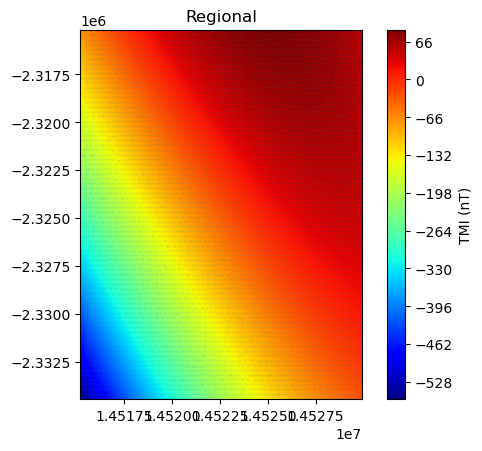

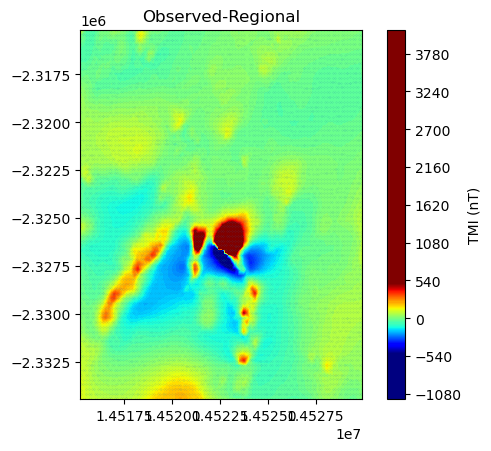

In [7]:
#Plot up the regional and obs-reg

vmax = 500
vmin = -vmax
im=plt.tricontourf(df.x,df.y,regional,cmap='jet',levels=500)
plt.title('Regional')
plt.scatter(df.x,df.y,s=.005)
plt.gca().set_aspect('equal')
plt.colorbar(im,label='TMI (nT)')
plt.show()

vmax = 500
vmin = -vmax
im=plt.tricontourf(df.x,df.y,dobs,cmap='jet',vmax=vmax,vmin=vmin,levels=500)
plt.scatter(df.x,df.y,s=.005)
plt.title('Observed-Regional')
plt.gca().set_aspect('equal')
plt.colorbar(im,label='TMI (nT)')
plt.show()

## Create Survey Object

In [8]:

receivers = mag.receivers.Point(rx_points,components='tmi')

#Define our source field
amplitude, inclination, declination = 51979.0, -53.17, 6.67

source_field = mag.sources.UniformBackgroundField(receiver_list=receivers, amplitude=amplitude, inclination=inclination, declination=declination)

#Define our survey
survey = mag.survey.Survey(source_field)

## Defining the mesh

In [9]:
import discretize

#Define cell size
cell_size_x = 100
cell_size_y = 100
cell_size_z = 75

#derive required number of padding cells
pad =25*(dist_x+dist_y)/2

nbc_x= int(2**np.rint(np.log2(pad/cell_size_x)))
nbc_y= int(2**np.rint(np.log2(pad/cell_size_y)))
nbc_z= int(2**np.rint(np.log2(pad/cell_size_z)))

hx = cell_size_x*np.ones(nbc_x)
hy = cell_size_y*np.ones(nbc_y)
hz = cell_size_z*np.ones(nbc_z)

#Define base mesh with zero cordinates in center (CCC)
mesh = discretize.TreeMesh(h=[hx, hy, hz], origin="CCC")

#Shift origin to center at reciever points
mesh.origin+=np.r_[mean_x,mean_y,mean_z]

#Refine the mesh with 4 Octree layers starting at the recievers and working downward
mesh.refine_surface(xyz=rx_points,level=-1,padding_cells_by_level=[8,8,8,6],pad_up=False,pad_down=True,finalize=False)

#Finalize our refinement
mesh.finalize()

mesh

OcTreeMesh,0.00% filled
Level,Number of cells
2,36
3,196
4,180
5,256
6,512
7,1075
8,2870
9,27635
10,69937


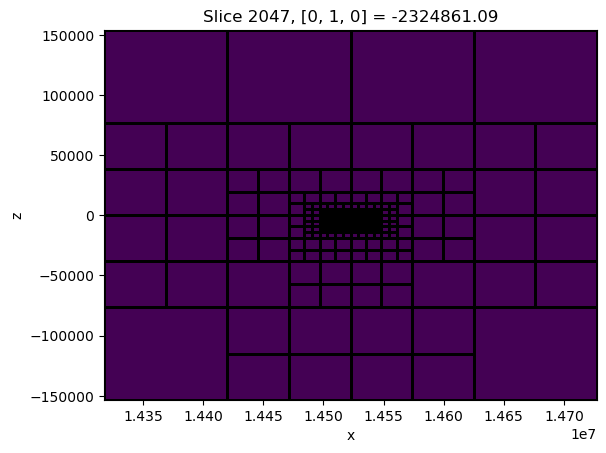

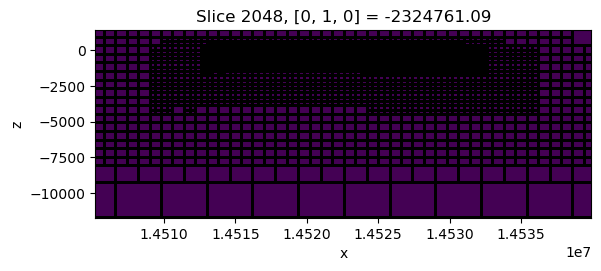

In [10]:
#Plot the entire mesh and around the core region

mesh.plot_slice(np.zeros(mesh.n_cells),slice_loc=mean_y, normal="y", grid=True, )
plt.gca().set_aspect("equal")
plt.show()

mesh.plot_slice(np.zeros(mesh.n_cells), normal="y", grid=True, )
plt.gca().set_aspect("equal")
plt.xlim(min_x-10000, max_x+10000)
plt.ylim(min_z-12000, max_z+1000)
plt.show()



In [11]:
#Define our active cells

mx_level=mesh.max_level

ind_active_topo = discretize.utils.active_from_xyz(mesh, topo)

#Small
max_active_level=-4
cl = mesh.cell_levels_by_index(np.arange(mesh.n_cells))

cond = (cl == mx_level)
for i in range(np.abs(max_active_level)-1):
    cond=cond+(cl == mx_level - (i+1))

active_cells = cond*ind_active_topo

n_active = np.sum(active_cells)

#array of booleans indicating active parameters
print(active_cells)
print(n_active)

[False False False ... False False False]
499705


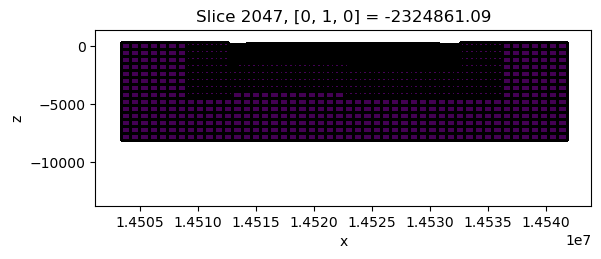

In [12]:
#Plot up the active region

from simpeg import maps

plotting_model = np.zeros(n_active)

plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan,nC=mesh.n_cells )

mesh.plot_slice(plotting_map*plotting_model, normal="y",slice_loc=mean_y, grid=True, )
plt.gca().set_aspect("equal")
plt.xlim(min_x-14000, max_x+14000)
plt.ylim(min_z-14000, max_z+1000)
plt.show()

# Defining the Simulation

For MVI, we solve in terms of the **total magnetization** $\mathbf{M}$.

To do this, we can treat $\mathbf{M}_r$ as $\mathbf{M}$ and set $\chi=\mu_0$.

The differential equation is:

$$
\nabla\cdot\mu_0\nabla\phi=\nabla\cdot\mu_0\mathbf{M}
$$

We can perform this with the code by only passing a mapping for **rem**

Because our lhs doesnt change, the solver only needs to perform the factorization once. We can store these factorization is float32 dtype to improve efficiency


In [13]:
from simpeg import maps
from simpeg.utils.solver_utils import get_default_solver


#Define the required mappings for the simulation
rem_injection = maps.InjectActiveCells(mesh, np.hstack((active_cells, active_cells, active_cells)), 0,nC=mesh.n_cells*3 )
EffectiveSusceptibilityMap = maps.EffectiveSusceptibilityMap(nP = n_active*3, ambient_field_magnitude = survey.source_field.amplitude)


mvi_map = rem_injection*EffectiveSusceptibilityMap

#Get the default solver for your system
solver = get_default_solver()

#Define the simulation
simulation = mag.simulation.Simulation3DDifferential(
    survey=survey,
    mesh = mesh,
    muMap=None,
    remMap=mvi_map,
    solver_dtype = np.float32,
    solver = solver
)

In [14]:
#Check time for initial forward, storage required for factorization

import psutil, os, time

process = psutil.Process(os.getpid())

mem_before = process.memory_info().rss / 1e6 
t0 = time.perf_counter()

model = np.random.randn(n_active*3)
simulation.dpred(model)

t1 = time.perf_counter()
mem_after = process.memory_info().rss / 1e6


print(f"Memory used for factorization: {mem_after - mem_before:.2f} MB")
print(f"Time for initial forward:  {t1 - t0:.3f} s")

Memory used for factorization: 1584.83 MB
Time for initial forward:  10.762 s


In [15]:
#Check time for additional forward (needs new model to clear fields)

t0 = time.perf_counter()

model = np.random.randn(n_active*3)
simulation.dpred(model)

t1 = time.perf_counter()
print(f"Time for additional forward:  {t1 - t0:.3f} s")

Time for additional forward:  0.784 s


## Regularization

In [16]:
from simpeg import regularization

regularization_map = maps.IdentityMap(nP=n_active*3)

#Vector amplitude mitigates artifacts
reg = regularization.VectorAmplitude(
        mesh,
        mapping=regularization_map,
        active_cells=active_cells,
        reference_model=np.zeros(n_active*3),
        alpha_s=.1,
        length_scale_x=1.0,
        length_scale_y=1.0,
        length_scale_z=1.0,
    )

#Norms for sparse inversion
reg.norms = [.5,1.2,1.2,1.2]


#Define weighting for regularization
#Exponent of 3 for magnetic data
exponent = 3

#Distance weights
distance_weights = utils.distance_weighting(mesh,survey.receiver_locations,active_cells=active_cells,exponent=exponent,)

#Depth weights
depth_weights = utils.depth_weighting(mesh,survey.receiver_locations,active_cells=active_cells,exponent=exponent,)

#Set the weights in our regularization
reg.set_weights(distance_weights=distance_weights+.01*depth_weights)

## Data misfit

In [17]:
from simpeg import data, data_misfit

relative_error = 0.00
noise_floor = .003 * np.max(np.abs(dobs))
data_object = data.Data(survey, dobs = dobs, relative_error = relative_error, noise_floor = noise_floor)
dmis = data_misfit.L2DataMisfit(data = data_object,simulation=simulation)



## Optimization

In each inversion iteration we minimize $\phi = \phi_d+\beta \phi_m$ with Gauss Newton Conjugate Gradient

Cool beta until $\phi_d = \phi_d^*$

In [18]:
from simpeg import optimization

#Define bounds of inversion
lower_bounds = -np.inf
upper_bounds = np.inf

# lower_bounds = -np.ones(n_active*3)
# upper_bounds = np.ones(n_active*3)

#Define optimizaiton and cg parameters
opt = optimization.ProjectedGNCG(
    maxIter=20, lower=lower_bounds, upper=upper_bounds, maxIterLS=4, cg_maxiter=50, cg_rtol=.1
)

## Directives

In [19]:
from simpeg import directives

#Estimate our initial beta value
beta = directives.BetaEstimate_ByEig(beta0_ratio=10)

In [20]:
#Custom preconditioner for our problem

from simpeg.utils import eigenvalue_by_power_iteration
from notebooks.Utils.aqgeo_utils import UpdatePreconditioner

start_model = np.zeros(n_active*3)+.0001

dm_eigenvalue = eigenvalue_by_power_iteration(
            dmis,
            start_model,
            n_pw_iter=5,
        )


jtj_approx = distance_weights*mesh.cell_volumes[active_cells]
jtj_approx = jtj_approx/np.max(jtj_approx)
jtj_approx*=dm_eigenvalue

pc_solver = get_default_solver()
update_jacobi = UpdatePreconditioner(solver=pc_solver,jtj_approx=np.tile(jtj_approx,3))



In [21]:
#Sparse norm inversion
#Cooling factor/cooling rate control beta cooling
#Runs for max_irls_iterations once chifact_start has been reached (if set to zero, equivalent to l2 inversion)

IRLS = directives.UpdateIRLS(max_irls_iterations=0, cooling_factor = 2,cooling_rate = 1,chifact_start=1,chifact_target=1,f_min_change = 1e-4)

## Setup and run inversion

In [22]:
from simpeg import inverse_problem,inversion

directive_list = [
    IRLS,
    beta,
    update_jacobi,
]

#We already have preconditioner, no init_bfgs
inv_prob = inverse_problem.BaseInvProblem(
    dmis, reg, opt, init_bfgs=False
)

inv = inversion.BaseInversion(
        inv_prob, directiveList=directive_list
    )



In [23]:
#Run the inversion
t0 = time.perf_counter()

recovered_model = inv.run(start_model)

t1 = time.perf_counter()

print(f"Time for inversion:  {t1 - t0:.3f} s")


Running inversion with SimPEG v0.25.0
================================================= Projected GNCG =================================================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS   iter_CG   CG |Ax-b|/|b|  CG |Ax-b|   Comment   
-----------------------------------------------------------------------------------------------------------------
   0  7.43e+00  1.56e+06  5.87e+01  1.56e+06                         0           inf          inf                
   1  7.43e+00  2.65e+05  3.50e+04  5.25e+05    1.29e+06      0      6        7.24e-02     9.31e+04              
   2  3.72e+00  1.50e+05  5.57e+04  3.57e+05    2.47e+05      0      7        8.73e-02     2.16e+04              
   3  1.86e+00  8.42e+04  8.03e+04  2.34e+05    1.65e+05      0      7        9.93e-02     1.64e+04              
   4  9.29e-01  4.45e+04  1.10e+05  1.47e+05    1.17e+05      0      9        9.18e-02     1.08e+04              
   5  4.65e-01  2.16e+04  1.44e+05  8.87e+04    

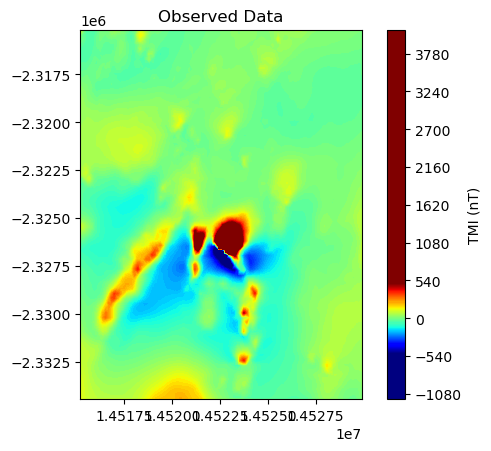

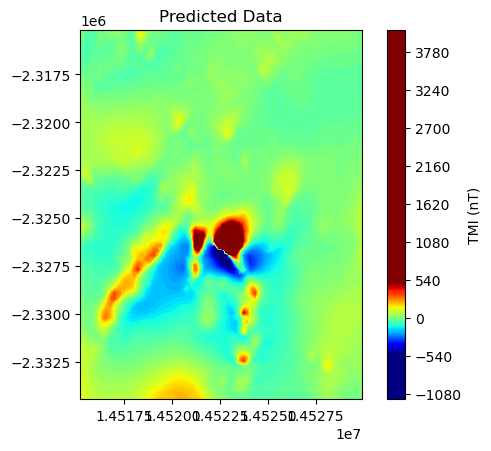

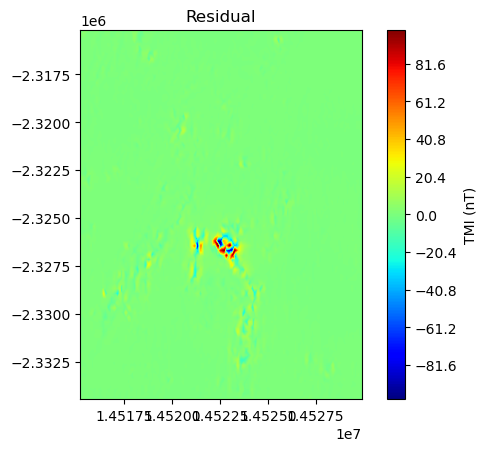

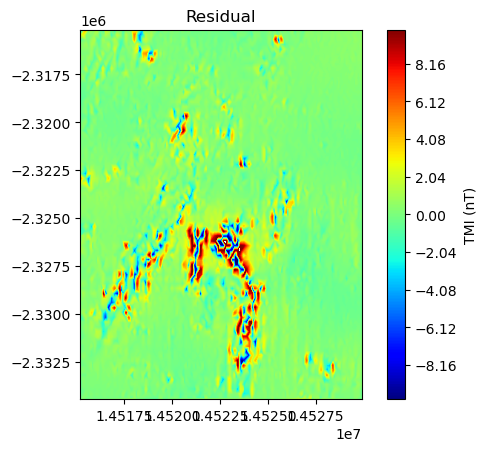

In [24]:

vmax = 500
vmin = -vmax
im=plt.tricontourf(df.x,df.y,dobs,cmap='jet',vmax=vmax,vmin=vmin,levels=500)
plt.title('Observed Data')
plt.gca().set_aspect('equal')
plt.colorbar(im,label='TMI (nT)')
plt.show()

im=plt.tricontourf(df.x,df.y,simulation.dpred(recovered_model),cmap='jet',vmax=vmax,vmin=vmin,levels=500)
plt.title('Predicted Data')
plt.gca().set_aspect('equal')
plt.colorbar(im,label='TMI (nT)')
plt.show()

resid=dmis.residual(recovered_model)

vmax = 100
vmin = -vmax
im=plt.tricontourf(df.x,df.y,np.clip(resid,-100,100),cmap='jet',vmax=vmax,vmin=vmin,levels=500)
plt.title('Residual')
plt.gca().set_aspect('equal')
plt.colorbar(im,label='TMI (nT)')
plt.show()

vmax = 10
vmin = -vmax
im=plt.tricontourf(df.x,df.y,np.clip(resid,-10,10),cmap='jet',vmax=vmax,vmin=vmin,levels=500)
plt.title('Residual')
plt.gca().set_aspect('equal')
plt.colorbar(im,label='TMI (nT)')
plt.show()


In [25]:


reshaped_model = recovered_model.reshape((-1,3),order='F')
model_amp = np.linalg.norm(reshaped_model,axis=1)
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan,nC=mesh.n_cells )

amp_plot = plotting_map*model_amp
vec_plot = plotting_map*reshaped_model


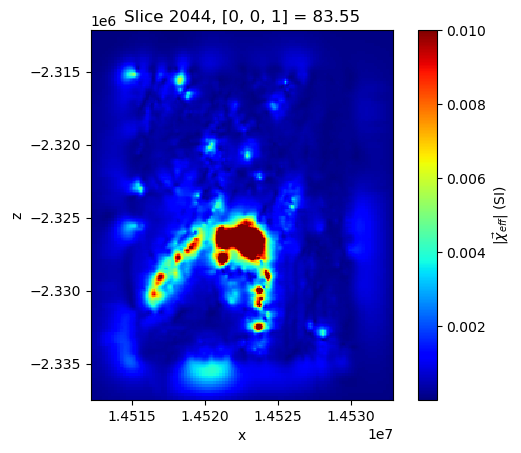

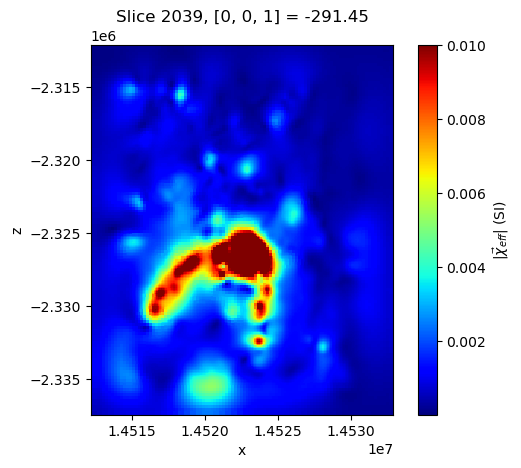

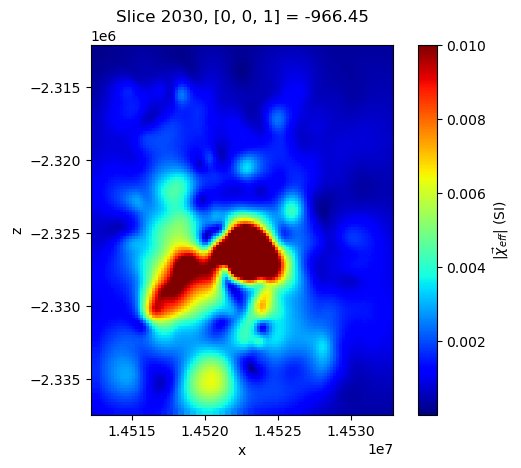

In [26]:
#Plot some depth slices

im=mesh.plot_slice(amp_plot, normal="z",slice_loc=100, grid=False, pcolorOpts={'vmax':.01,'cmap':'jet'})
plt.gca().set_aspect("equal")
plt.colorbar(im[0],label=r'$|\vec{\chi}_{eff}|$ (SI)')
plt.xlim(min_x-3000, max_x+3000)
plt.ylim(min_y-3000, max_y+3000)
plt.show()

im=mesh.plot_slice(amp_plot, normal="z",slice_loc=-300, grid=False, pcolorOpts={'vmax':.01,'cmap':'jet'})
plt.gca().set_aspect("equal")
plt.xlim(min_x-3000, max_x+3000)
plt.ylim(min_y-3000, max_y+3000)
plt.colorbar(im[0],label=r'$|\vec{\chi}_{eff}|$ (SI)')
plt.show()

im=mesh.plot_slice(amp_plot, normal="z",slice_loc=-1000, grid=False, pcolorOpts={'vmax':.01,'cmap':'jet'})
plt.gca().set_aspect("equal")
plt.xlim(min_x-3000, max_x+3000)
plt.ylim(min_y-3000, max_y+3000)
plt.colorbar(im[0],label=r'$|\vec{\chi}_{eff}|$ (SI)')
plt.show()

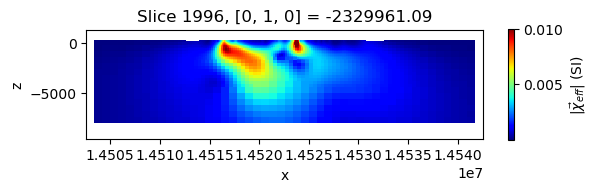

In [27]:
#Plot a cross section of amplitude

im=mesh.plot_slice(amp_plot, normal="y",slice_loc=-2330000, grid=False,pcolorOpts={'vmax':.01,'cmap':'jet'} )
plt.gca().set_aspect("equal")
plt.xlim(mean_x-20000, mean_x+20000)
plt.ylim(mean_z-10000, mean_z+1000)
plt.colorbar(im[0],label=r'$|\vec{\chi}_{eff}|$ (SI)',shrink=.3)
plt.show()

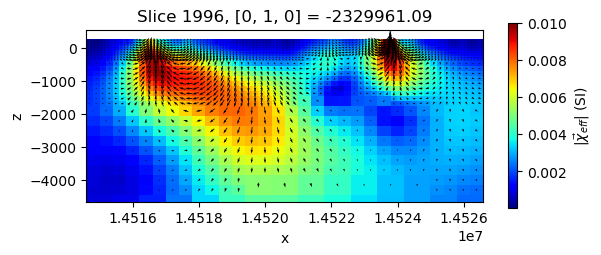

In [28]:
#Plot vector field cross section

im=mesh.plot_slice(vec_plot, normal="y",slice_loc=-2330000, grid=False,pcolorOpts={'vmax':.01,'cmap':'jet'},view="vec",v_type="CCv",quiver_opts={
                "pivot": "mid",
                "scale": .1,
                "width":.002,
                "scale_units": "inches",
            },)
plt.gca().set_aspect("equal")
plt.xlim(mean_x-8000, mean_x+4000)
plt.ylim(mean_z-5000, mean_z+200)
plt.colorbar(im[0][0],label=r'$|\vec{\chi}_{eff}|$ (SI)',shrink=.5)
plt.show()

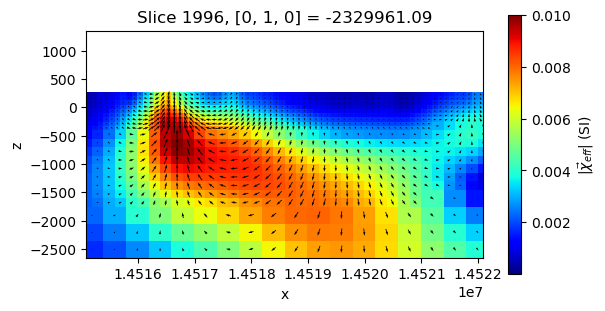

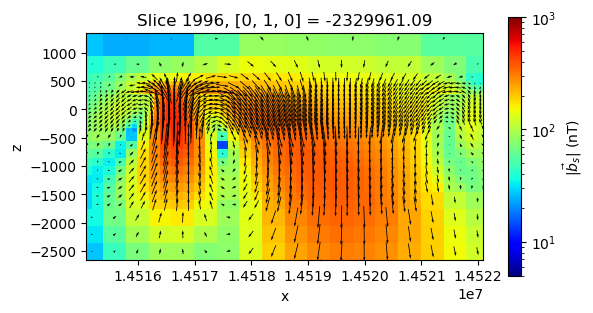

In [29]:
im=mesh.plot_slice(vec_plot, normal="y",slice_loc=-2330000, grid=False,pcolorOpts={'vmax':.01,'cmap':'jet'},view="vec",v_type="CCv",quiver_opts={
                "pivot": "mid",
                "scale": .1,
                "width":.002,
                "scale_units": "inches",
            },)
plt.gca().set_aspect("equal")
plt.xlim(mean_x-7500, mean_x-500)
plt.ylim(mean_z-3000, mean_z+1000)
plt.colorbar(im[0][0],label=r'$|\vec{\chi}_{eff}|$ (SI)',shrink=.7)
plt.show()

from matplotlib import colors
bfield = simulation.fields(recovered_model)["b"]

bfield=mesh.average_face_to_cell_vector*bfield

b_plot = bfield.reshape((-1,3),order='F')

im=mesh.plot_slice(b_plot, normal="y",slice_loc=-2330000, grid=False,
                pcolorOpts={'cmap':'jet','norm': colors.LogNorm(vmin=5, vmax=1e3)},
                view="vec",v_type="CCv",quiver_opts={
                "pivot": "mid",
                "scale": 1500,
                "width":.002,
                "scale_units": "inches",
            },)
plt.gca().set_aspect("equal")
plt.xlim(mean_x-7500, mean_x-500)
plt.ylim(mean_z-3000, mean_z+1000)
plt.colorbar(im[0][0],shrink=.7,label=r"$|\vec{b}_s|$ (nT)")
plt.show()